In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.5.1+cu121'

In [4]:
train_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
image, label = train_data[0]

In [6]:
len(train_data.data), len(train_data.targets)

(50000, 50000)

In [7]:
len(test_data.data), len(train_data.targets)

(10000, 50000)

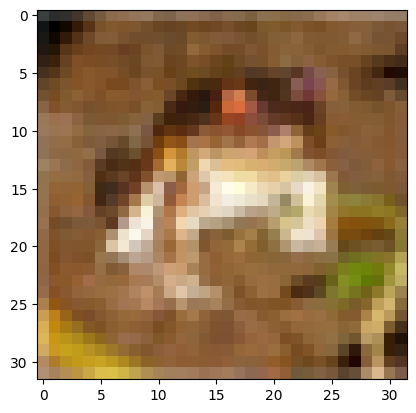

In [8]:
plt.imshow(torch.permute(image, (1, 2, 0)))

In [9]:
class_names = train_data.classes

In [10]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image shape: torch.Size([3, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

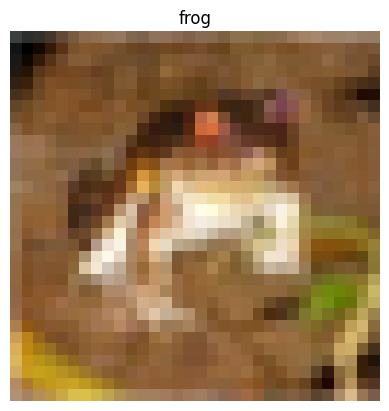

In [11]:
print(f"Image shape: {image.shape}")
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.title(class_names[label])
plt.axis('off')

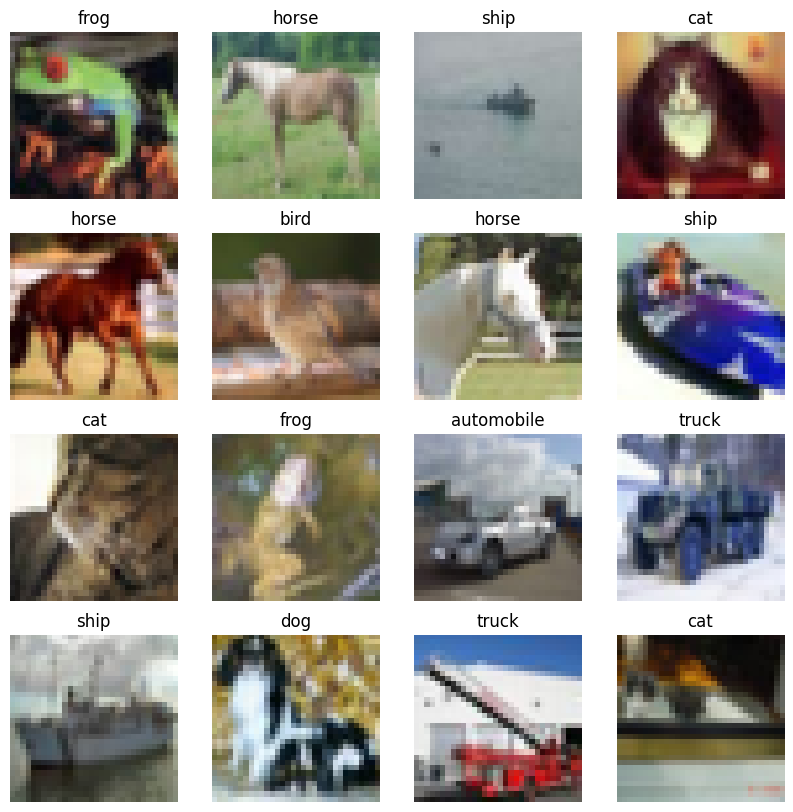

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize = (10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis(False);

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [14]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a560137dc90>, <torch.utils.data.dataloader.DataLoader object at 0x7a560137e6b0>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


In [15]:
train_features_batch, train_features_label = next(iter(train_dataloader))

In [16]:
train_features_batch.shape, train_features_label.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image size: torch.Size([3, 32, 32])
Label: 8, label size: torch.Size([])


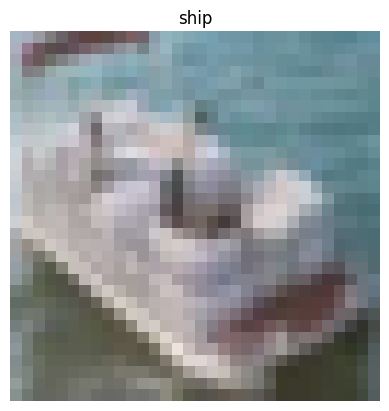

In [17]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_features_label[random_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [18]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 1024]) -> [color_channels, height*width]


In [19]:
class FashionMNISTModelv0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
        )

  def forward(self, x):
    return self.layer_stack(x)

In [20]:
model_0 = FashionMNISTModelv0(
    input_shape = 3072,
    hidden_units = 128,
    output_shape = len(class_names)
)

In [21]:
model_0

FashionMNISTModelv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [22]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [24]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device : torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = start - end
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time

In [25]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # Flatten input if it's an image tensor
    X = X.view(X.size(0), -1)  # (batch_size, features)

    # Forward pass
    y_pred = model_0(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_dataloader)

  ### Testing
  # Setup variables for accumulatively adding up loss and accuracy
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

      # 3. Calculate accuracy (preds need to be same as y_true)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

      # Calculations on test metrics need to happen inside torch.inference_mode()
      # Divide total test loss by length of test dataloader (per batch)
      test_loss /= len(test_dataloader)

      # Divide total accuracy by length of test dataloader (per batch)
      test_acc /= len(test_dataloader)

  ## Print out what's happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                            end = train_time_end_on_cpu,
                                            device = str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 1.95684 | Test loss: 0.00565, Test acc: 0.08%

Epoch: 1
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 1.81331 | Test loss: 0.00567, Test acc: 0.08%

Epoch: 2
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 1.75713 | Test loss: 0.00503, Test acc: 0.08%

Train time on cpu : -38.580 seconds


In [26]:
torch.manual_seed(42)
def eval_mode(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader.

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
      data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Make predictions with the model
      y_pred = model(X)

      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc}

In [27]:
# Calculate model 0 results on test dataset
model_0_results = eval_mode(model = model_0,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelv0',
 'model_loss': 1.7434366941452026,
 'model_acc': 38.33865814696485}

In [28]:
import torch
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
class FashionMNISTModelv1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
        )

  def forward(self, x):
    return self.layer_stack(x)

In [30]:
model_1 = FashionMNISTModelv1(
    input_shape = 3072,
    hidden_units = 128,
    output_shape = len(class_names)
).to(device)

In [31]:
model_1

FashionMNISTModelv1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=10, bias=True)
    (8): ReLU()
  )
)

In [32]:
list(model_1.parameters())

[Parameter containing:
 tensor([[-0.0042,  0.0166, -0.0040,  ...,  0.0092, -0.0045,  0.0016],
         [-0.0048, -0.0177, -0.0019,  ..., -0.0039, -0.0143,  0.0034],
         [-0.0036,  0.0136, -0.0179,  ..., -0.0045,  0.0112, -0.0093],
         ...,
         [-0.0152,  0.0108,  0.0079,  ..., -0.0012, -0.0123,  0.0157],
         [ 0.0147, -0.0135, -0.0080,  ...,  0.0116, -0.0040,  0.0035],
         [ 0.0158, -0.0106, -0.0013,  ..., -0.0096, -0.0092, -0.0087]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-6.1563e-03,  5.0861e-03,  2.6120e-03, -4.7244e-04, -9.9165e-03,
          6.9310e-03,  1.5608e-02, -1.7137e-02, -7.8244e-04,  3.5188e-03,
         -1.6984e-02, -5.4005e-03, -7.5982e-03, -1.1384e-02, -9.8695e-03,
          1.4704e-03,  2.2716e-03,  1.5896e-02,  5.8236e-03, -3.5786e-03,
         -1.3979e-02, -1.6377e-02,  1.2893e-02, -2.6291e-03, -1.0866e-02,
         -5.6220e-03, -1.0760e-02,  1.5344e-02, -1.2833e-02,  4.8345e-03,
          6.0880e-03, -

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [35]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [36]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader = train_dataloader,
             model = model_1,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn)
  test_step(data_loader = test_dataloader,
            model = model_1,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.20305 | Train accuracy: 21.96%
Test loss: 2.08859 | Test accuracy: 25.87%

Epoch: 1
---------
Train loss: 2.06217 | Train accuracy: 29.95%
Test loss: 2.08845 | Test accuracy: 28.45%

Epoch: 2
---------
Train loss: 1.89098 | Train accuracy: 34.84%
Test loss: 1.71716 | Test accuracy: 37.72%

Train time on cuda : -34.252 seconds


In [37]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelv1',
 'model_loss': 1.717158555984497,
 'model_acc': 37.71964856230032}

In [67]:
class FashionMNISTModelv2(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Placeholder for the classifier, to be initialized dynamically
        self.classifier = None

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)

        # Dynamically calculate in_features for the Linear layer
        if self.classifier is None:
            # Calculate the flattened feature size dynamically
            flattened_size = x.view(x.size(0), -1).size(1)
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features=flattened_size, out_features=10)  # Assuming 10 output classes
            ).to(x.device)  # Ensure it's on the same device as the input

        x = self.classifier(x)
        return x

In [70]:
torch.manual_seed(42)
model_2 = FashionMNISTModelv2(input_channels=3,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelv2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [71]:
list(model_2.parameters())

[Parameter containing:
 tensor([[[[ 0.1471,  0.1597, -0.0451],
           [ 0.1768, -0.0422,  0.0388],
           [-0.0937,  0.1130,  0.1697]],
 
          [[-0.1412,  0.1673,  0.0360],
           [ 0.1422,  0.0261,  0.0928],
           [-0.0272,  0.1484,  0.0284]],
 
          [[-0.0898,  0.0491, -0.0887],
           [-0.0226, -0.0782,  0.1277],
           [-0.1519, -0.0887, -0.0543]]],
 
 
         [[[-0.1157,  0.0182, -0.1901],
           [ 0.1738, -0.1635,  0.1486],
           [ 0.0320, -0.0625,  0.1189]],
 
          [[ 0.0300,  0.1555,  0.0210],
           [-0.0607,  0.0517, -0.0522],
           [ 0.0810,  0.1718,  0.1112]],
 
          [[-0.0841,  0.1111,  0.0344],
           [ 0.0977, -0.1173, -0.1905],
           [-0.0744, -0.1476,  0.1579]]],
 
 
         [[[ 0.0554,  0.0797,  0.0609],
           [-0.0033,  0.1506, -0.1367],
           [ 0.0121, -0.1314,  0.0593]],
 
          [[-0.0663,  0.0590, -0.0401],
           [ 0.1596, -0.1141, -0.1148],
           [-0.1148,  0.1731, 

In [72]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [73]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [74]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [75]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [76]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [77]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())

OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],

In [78]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [79]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [80]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [81]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

In [82]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30278 | Train accuracy: 10.02%
Test loss: 2.30242 | Test accuracy: 10.04%

Epoch: 1
---------
Train loss: 2.25617 | Train accuracy: 14.93%
Test loss: 2.15423 | Test accuracy: 20.82%

Epoch: 2
---------
Train loss: 2.08674 | Train accuracy: 23.34%
Test loss: 2.06157 | Test accuracy: 25.63%

Train time on cuda : -37.738 seconds


In [83]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelv2',
 'model_loss': 2.06156849861145,
 'model_acc': 25.62899361022364}

In [84]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelv0,1.743437,38.338658
1,FashionMNISTModelv1,1.717159,37.719649
2,FashionMNISTModelv2,2.061568,25.628994


In [85]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelv0,1.743437,38.338658,-38.580157
1,FashionMNISTModelv1,1.717159,37.719649,-34.252499
2,FashionMNISTModelv2,2.061568,25.628994,-37.738419


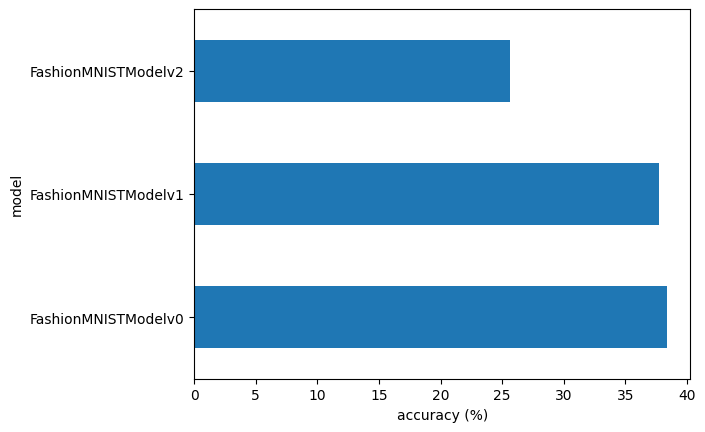

In [86]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [87]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [88]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 9 (truck)


In [89]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.0724, 0.1039, 0.1465, 0.0328, 0.0862, 0.0698, 0.0566, 0.2925, 0.0215,
         0.1179],
        [0.1176, 0.0870, 0.0473, 0.2606, 0.1102, 0.0896, 0.0607, 0.0903, 0.0634,
         0.0733]])

In [90]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 3, 9, 4, 6, 2, 7, 0, 0])

In [91]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([9, 2, 1, 3, 7, 3, 7, 0, 9], tensor([7, 3, 9, 4, 6, 2, 7, 0, 0]))

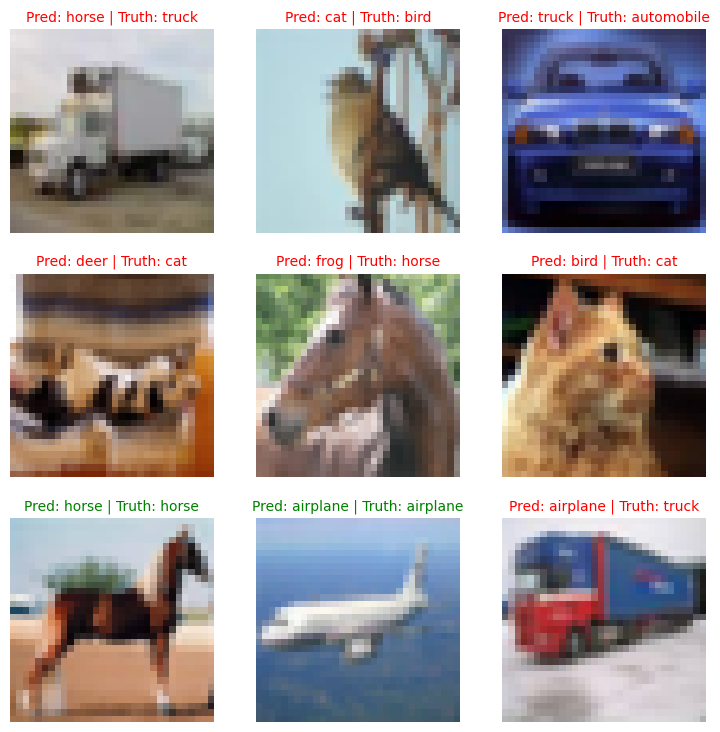

In [93]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);